# Fitting the best model on full dataset

From the preliminary analysis, random forest with all features resulted in the best performance. So we are going to use weighted random forest on the full dataset (to account for class imbalance).

Steps:
1. Load full dataset and do transformations.
2. Fit weighted random forest.
3. Test performance.

## Transform full dataset

In [1]:
#Load libraries
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import power_transform
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Read original data
df = pd.read_csv("data/covtype.csv")
print(df.shape)

(581012, 55)


In [3]:
#keep only the variables we selected
final_df = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type10',
       'Soil_Type23','Soil_Type29', 'Soil_Type30',
        'Soil_Type32', 'Cover_Type']]
final_df = final_df.reset_index(drop=True)

In [4]:
#Look at the distributions of varibales in the full dataset
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


In [5]:
#Repeating the transformations we did in EDA part
#select only numeric variables
numeric_df = final_df.iloc[:, :-10]
numeric_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,2596,51,3,258,0,510,221,232,148,6279
1,2590,56,2,212,-6,390,220,235,151,6225
2,2804,139,9,268,65,3180,234,238,135,6121
3,2785,155,18,242,118,3090,238,238,122,6211
4,2595,45,2,153,-1,391,220,234,150,6172
...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837
581008,2391,152,19,67,12,95,240,237,119,845
581009,2386,159,17,60,7,90,236,241,130,854
581010,2384,170,15,60,5,90,230,245,143,864


In [6]:
#add a constant to vertical distance to hydrology to remove negative values and be able to transform
numeric_df['Vertical_Distance_To_Hydrology'] = numeric_df['Vertical_Distance_To_Hydrology'] + 173

In [7]:
#log transform skewed variables and add 1 to remove zeros
numeric_df["Horizontal_Distance_To_Hydrology"] = np.log(numeric_df["Horizontal_Distance_To_Hydrology"]+1)
numeric_df["Vertical_Distance_To_Hydrology"] = np.log(numeric_df["Vertical_Distance_To_Hydrology"]+1)
numeric_df["Horizontal_Distance_To_Roadways"] = np.log(numeric_df["Horizontal_Distance_To_Roadways"]+1)
numeric_df["Horizontal_Distance_To_Fire_Points"] = np.log(numeric_df["Horizontal_Distance_To_Fire_Points"]+1)

In [8]:
#square variables to remove negative skewness
numeric_df["Hillshade_9am"] = np.square(numeric_df["Hillshade_9am"])
numeric_df["Hillshade_Noon"] = np.square(numeric_df["Hillshade_Noon"])

In [9]:
#Transform aspect by converting to radians and taking cosine 
numeric_df['Aspect'] = np.cos(np.radians(numeric_df['Aspect']))

In [10]:
#standardize numeric variables
for column in numeric_df:
    mean = np.mean(numeric_df[column])
    sd = np.std(numeric_df[column])
    numeric_df[column] = (numeric_df[column]-mean)/sd

In [11]:
## df_combined will be our final dataset
category_df = final_df.iloc[:, -10:]
df_combined = pd.concat([numeric_df, category_df], axis=1)
df_combined  

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area3,Wilderness_Area4,Soil_Type3,Soil_Type4,Soil_Type10,Soil_Type23,Soil_Type29,Soil_Type30,Soil_Type32,Cover_Type
0,-1.297805,0.658804,-1.482820,0.333025,-0.867052,-1.495183,0.294964,0.422002,0.142960,1.871076,0,0,0,0,0,0,1,0,0,5
1,-1.319235,0.557026,-1.616363,0.190033,-1.014305,-1.815518,0.253251,0.587986,0.221342,1.859448,0,0,0,0,0,0,1,0,0,5
2,-0.554907,-1.349871,-0.681563,0.360728,0.464875,0.693241,0.854449,0.756102,-0.196691,1.836768,0,0,0,0,0,0,0,0,0,2
3,-0.622768,-1.569889,0.520322,0.286394,1.305345,0.658892,1.033031,0.756102,-0.536343,1.856417,0,0,0,0,0,0,0,1,0,2
4,-1.301377,0.771697,-1.616363,-0.047150,-0.891238,-1.812461,0.253251,0.532421,0.195215,1.847938,0,0,0,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,-2.012130,-1.547682,0.787408,-0.473199,-0.475885,-3.344246,1.123456,0.699826,-0.640851,-0.840742,1,0,0,0,0,0,0,0,0,3
581008,-2.029988,-1.535986,0.653865,-0.644932,-0.587198,-3.496238,1.123456,0.699826,-0.614724,-0.827949,1,0,0,0,0,0,0,0,0,3
581009,-2.047847,-1.609470,0.386780,-0.724374,-0.701545,-3.560252,0.943362,0.926351,-0.327327,-0.813701,1,0,0,0,0,0,0,0,0,3
581010,-2.054990,-1.683818,0.119694,-0.724374,-0.748170,-3.560252,0.678895,1.156666,0.012325,-0.798045,1,0,0,0,0,0,0,0,0,3


In [12]:
#saving transformed data
df_combined.to_csv('Transformed_Data_Full.csv', index=False)

## Fitting the best model - Random Forest

Using weights that are inversely proportional to the frequency of class observatons.

In [13]:
#select features and response variable
features = df_combined.drop(columns=["Cover_Type"])
cover_type = df_combined["Cover_Type"]

In [14]:
## Split data into train and test.
train_df, test_df = train_test_split(df_combined, test_size=0.3, random_state=123) ## 70% train data and 30% test data
X_train = train_df.drop(columns=["Cover_Type"])
X_test = test_df.drop(columns=["Cover_Type"])
y_train = train_df["Cover_Type"]
y_test = test_df["Cover_Type"]
features = X_train.columns.to_list()

In [15]:
#function that outputs prediction intervals (50 and 80 %) from prob. matrix
def category_pred_interval(prob_matrix, labels):
    ncases = prob_matrix.shape[0]
    pred50 = [None] * ncases
    pred80 = [None] * ncases
    
    for i in range(ncases):
        p = prob_matrix[i, :]
        ip = np.argsort(p)[::-1]  # Sort probabilities in decreasing order
        p_ordered = p[ip]
        labels_ordered = np.array(labels)[ip]
        
        G = np.cumsum(p_ordered)  # Cumulative sum from largest
        
        k1 = np.min(np.where(G >= 0.5))  # level1 = 0.5
        k2 = np.min(np.where(G >= 0.8))  # level2 = 0.8
        
        pred1 = labels_ordered[:k1 + 1]
        pred2 = labels_ordered[:k2 + 1]
        
        pred50[i] = "".join(map(str, pred1))
        pred80[i] = "".join(map(str, pred2))

    return {"pred50": pred50, "pred80": pred80}

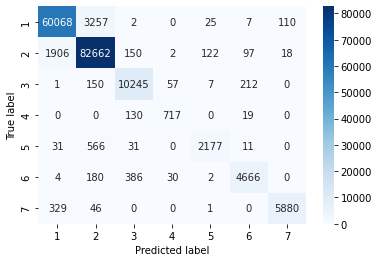

              precision    recall  f1-score   support

           1       0.96      0.95      0.95     63469
           2       0.95      0.97      0.96     84957
           3       0.94      0.96      0.95     10672
           4       0.89      0.83      0.86       866
           5       0.93      0.77      0.85      2816
           6       0.93      0.89      0.91      5268
           7       0.98      0.94      0.96      6256

    accuracy                           0.95    174304
   macro avg       0.94      0.90      0.92    174304
weighted avg       0.95      0.95      0.95    174304



In [16]:
## Running Random forest with all features
#producing the out of sample predictions confusion matrix
rf =  RandomForestClassifier(random_state=447, n_jobs=-1, class_weight = 'balanced')
rf.fit(X_train, y_train)
rf_accuracy = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm1,
    annot=True,
    cmap='Blues',
    fmt='g',
    annot_kws={'fontsize': 10},
    xticklabels=['1','2','3','4','5','6','7'],
    yticklabels=['1','2','3','4','5','6','7']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print(classification_report(y_test, y_pred))

In [17]:
## Random Forest holdout set prediction intervals
pd.set_option('display.max_columns', 94)
prob_matrix = rf.predict_proba(X_test)
labels = rf.classes_
intervals = category_pred_interval(prob_matrix, labels)
pred50 = intervals["pred50"]
pred80 = intervals["pred80"]
# Create a DataFrame with the true labels and the predicted 50% interval
data50 = {'True_Labels': y_test, 'Pred50': pred50}
data80 = {'True_Labels': y_test, 'Pred80': pred80}
df50 = pd.DataFrame(data50)
df80 = pd.DataFrame(data80)
cross_tab50 = pd.crosstab(df50['True_Labels'], df50['Pred50'])
print("50% Prediction Interval:")
print(cross_tab50)

# Calculate cross-tabulation for 80% interval
cross_tab80 = pd.crosstab(df80['True_Labels'], df80['Pred80'])
print("80% Prediction Interval:")
print(cross_tab80)

50% Prediction Interval:
Pred50           1  12  13  15  16  17      2  21  23  25  26  27      3  31  \
True_Labels                                                                    
1            59828  78   5  11   8   5   3287  87   2   5   1   0      1   0   
2             1786  26   1   1   0   2  82565  50  42  21  51   6    115   0   
3                1   0   0   0   0   0    116   1  24   1   6   0  10083   2   
4                0   0   0   0   0   0      0   0   0   0   0   0     96   0   
5               14   6   0  11   0   0    483  11   3  58   2   0     22   0   
6                0   3   0   0   1   0    100   3   6   0  62   0    303   0   
7              293   3   0   0   0  29     29   9   0   0   0   7      0   0   

Pred50       32  34  35  36    4  42  43  46     5  51  52  53  56     6  61  \
True_Labels                                                                    
1             1   0   0   0    0   0   0   0     8  14   5   0   0     4   2   
2            3

In [78]:
#calculating accuracy 
#counts the number of correct predictions in the df
correct = 0
for i in range(174304):
    if str(y_test.tolist()[i]) in intervals["pred80"][i]:
        correct += 1


In [77]:
#50 % PI accuracy
correct/174304

0.9579757205801358

In [79]:
#80 % PI accuracy
correct/174304

0.9950546172204884